<a href="https://colab.research.google.com/github/stefsyrsiri/synthetic-image-detection/blob/preprocessing-functions/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting AI-Generated Synthetic Images

The boom of AI-powered content generation and increasing interest in the research field of Deep Learning has led to widely accessible (and trending) tools that can produce content of any kind: text, image, audio, and video. This high GenAI trend has even led to the advancedment of existing tools, that had been forgotten. AI-generated content can often be indistinguishable from its authentic counterparts, posing a threat to the credibility of digital media. The underlying dangers of the misuse of GenAI have already come to surface with deepfakes, voice cloning, fakes news, disinformation, identity theft and various types of scams.

In this report, we focus on image generation, which can have multiple societal effects, especially on people not familiar with this kind of technology. Our task is to train a neural network to identify whether an image is real or AI-generated.



In [ ]:
# Project overview
# TO-DO: Add statistics from credible sources / read papers
# TO-DO: Find media to add / Try to find high-res images from the dataset
# 1. CNN
# 2. Transfer learning
# 3. Demo

In [1]:
# Import packages and classes
# Data Handling
import os
import sys
from PIL import Image
import pandas as pd
import numpy as np

# PyTorch and CV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, v2
import torchvision.transforms.v2 as v2_transforms
import cv2

# Visualization and Evaluation
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# Classes
!git clone https://github.com/stefsyrsiri/synthetic-image-detection.git
sys.path.append('/content/synthetic-image-detection')
from testpy import test
test

#TO-DO: Do we need the following?
# import tensorflow
# from tensorflow.keras import Model #Model class for instantiating the ResNet that you will be creating.


# #These are all described in standard deep learning literature (e.g. Conv2Dor Dense). Why they are necessary can be found in the He et al. (2016) paper.
# from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
# Dense, Flatten, Conv2D, Lambda, Input, BatchNormalization, Activation schedules and the Stochastic Gradient Descent optimizer for optimization purposes.
# from tensorflow.keras.optimizers import schedules, SGD

# For visualizing your training results and saving your model, respectively.
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


Cloning into 'synthetic-image-detection'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 115 (delta 19), reused 1 (delta 1), pack-reused 47
Receiving objects: 100% (115/115), 2.28 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (31/31), done.


'>>^ω^<<'

## Dataset

The dataset we're using to train our classifier is **[CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)**, which can be found on Kaggle.

CIFAKE is a comprehensive collection of 60,000 synthetically-generated images and 60,000 real images (collected from CIFAR-10). The dataset contains two classes, labelled as "REAL" and "FAKE".

In [ ]:
# The dataset exceeds Github's limits and needs to be downloaded directly from Kaggle
# Register / Login to Kaggle
# Create a token (key) for their free API

# API INSTRUCTIONS
#-------------------------------------------------------------------------------
# Login to Kaggle on your browser -> Click on your profile picture in the top right corner -> Settings -> API -> Create New Token
# After running the cell CLEAR the cell's output. :)
KAGGLE_USERNAME = input("Enter your Kaggle username: ")
KAGGLE_KEY = input("Enter your Kaggle key: ")

os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [2]:
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 91% 95.0M/105M [00:00<00:00, 121MB/s]
100% 105M/105M [00:00<00:00, 112MB/s] 


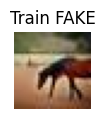

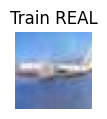

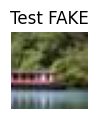

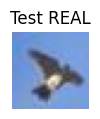

In [3]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[6])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# TO-DO: Display the images nicely
# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [4]:
# Our classes' labels
# TO-DO: print the labels for both sets
LABELS = np.asarray(os.listdir('train'))
print(LABELS)

['FAKE' 'REAL']


In [13]:
# Create the training and test datasets with ImageFolder class from PyTorch
# Training dataset
train_set = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set: {len(train_set)}") #TO-DO: Can we format this to look like 100,000?

# Validation dataset
test_set  = datasets.ImageFolder(root='test')
print(f"Test set: {len(test_set)}")
#TO-DO: Add some graphs showing the size of the training and test set

Training set: 100000
Test set: 20000


Training set: 100,000
Test set: 20,000
Batch image shape: torch.Size([10, 3, 32, 32])
Image 1 shape: torch.Size([3, 32, 32])
Image 2 shape: torch.Size([3, 32, 32])
Image 3 shape: torch.Size([3, 32, 32])
Image 4 shape: torch.Size([3, 32, 32])
Image 5 shape: torch.Size([3, 32, 32])
Image 6 shape: torch.Size([3, 32, 32])
Image 7 shape: torch.Size([3, 32, 32])
Image 8 shape: torch.Size([3, 32, 32])
Image 9 shape: torch.Size([3, 32, 32])
Image 10 shape: torch.Size([3, 32, 32])


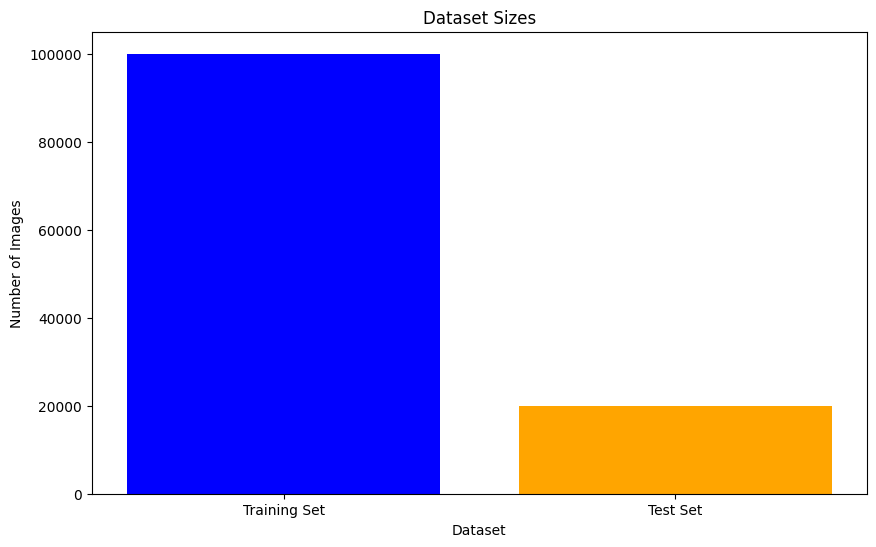

In [24]:
# CHATGPT
# Transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the training and test datasets
train_set = datasets.ImageFolder(root='train', transform=transform)
test_set = datasets.ImageFolder(root='test', transform=transform)

# Print the size of the datasets
print(f"Training set: {len(train_set):,}")
print(f"Test set: {len(test_set):,}")

# Inspect image dimensions
def inspect_image_dimensions(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Use next() instead of .next()
    print(f"Batch image shape: {images.shape}")
    for i in range(images.shape[0]):
        print(f"Image {i+1} shape: {images[i].shape}")

inspect_image_dimensions(train_set)

# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(test_set)]
dataset_labels = ['Training Set', 'Test Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

# Visualize some samples from the training set
def show_images(dataset, num_images=5):
    loader = torch.utils.data.D

Batch image shape: torch.Size([16, 3, 32, 32])
Batch labels: tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])


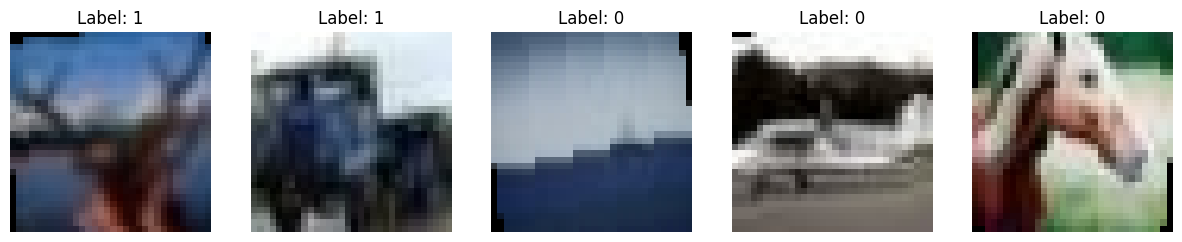

In [26]:
# CHATGPT

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),      # Random rotation
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define transformations for the validation set without data augmentation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Create the training and validation datasets
train_set = datasets.ImageFolder(root='train', transform=train_transform)
val_set = datasets.ImageFolder(root='test', transform=val_transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Check a batch of images and labels to verify preprocessing
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch image shape: {images.shape}")
print(f"Batch labels: {labels}")

# Visualize some sample images to verify augmentations
def show_images(images, labels, num_images=5):
    images = images / 2 + 0.5  # Unnormalize
    np_images = images.numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(np.transpose(np_images[i], (1, 2, 0)))
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

show_images(images, labels)

In [43]:
# CHATGPT

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Assuming input images are 32x32
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # 1 output neuron

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor before the fully connected layers
        x = x.view(-1, 128 * 4 * 4)  # Flattening

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x



import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),      # Random rotation
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define transformations for the validation set without data augmentation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Create the training and validation datasets
train_set = datasets.ImageFolder(root='train', transform=train_transform)
val_set = datasets.ImageFolder(root='test', transform=val_transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the model, criterion, and optimizer
model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)

        # Reshape labels to match the output shape
        labels = labels.view(-1, 1).float()  # Ensure labels are of shape [batch_size, 1]

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            labels = labels.view(-1, 1).float()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed. Validation Loss: {val_loss:.4f}')

print('Training complete')

Epoch [1/20], Step [100/6250], Loss: 0.5283
Epoch [1/20], Step [200/6250], Loss: 0.5759
Epoch [1/20], Step [300/6250], Loss: 0.3976
Epoch [1/20], Step [400/6250], Loss: 0.3537
Epoch [1/20], Step [500/6250], Loss: 0.6750
Epoch [1/20], Step [600/6250], Loss: 0.4789
Epoch [1/20], Step [700/6250], Loss: 0.3879
Epoch [1/20], Step [800/6250], Loss: 0.5706
Epoch [1/20], Step [900/6250], Loss: 0.2769
Epoch [1/20], Step [1000/6250], Loss: 0.3766
Epoch [1/20], Step [1100/6250], Loss: 0.1958
Epoch [1/20], Step [1200/6250], Loss: 0.4183
Epoch [1/20], Step [1300/6250], Loss: 0.2305
Epoch [1/20], Step [1400/6250], Loss: 0.2537
Epoch [1/20], Step [1500/6250], Loss: 0.5467
Epoch [1/20], Step [1600/6250], Loss: 0.6259
Epoch [1/20], Step [1700/6250], Loss: 0.2616
Epoch [1/20], Step [1800/6250], Loss: 0.2736
Epoch [1/20], Step [1900/6250], Loss: 0.6116
Epoch [1/20], Step [2000/6250], Loss: 0.4000
Epoch [1/20], Step [2100/6250], Loss: 0.2541
Epoch [1/20], Step [2200/6250], Loss: 0.3919
Epoch [1/20], Step 

In [46]:
val_loss

0.2089351641523528

In [53]:
predictions = (outputs > 0.5).float()  # Thresholding at 0.5 for sigmoid output
correct = torch.eq(predictions, labels).float().mean()
accuracy = correct * 100  # Calculate percentage accuracy
from sklearn.metrics import f1_score
f1 = f1_score(labels.cpu().numpy(), predictions.cpu().numpy()) * 100

In [60]:
print(f"Accuracy: {accuracy:.2f}%\nF1: {f1:.2f}%")

Accuracy: 93.75%
F1: 96.77%


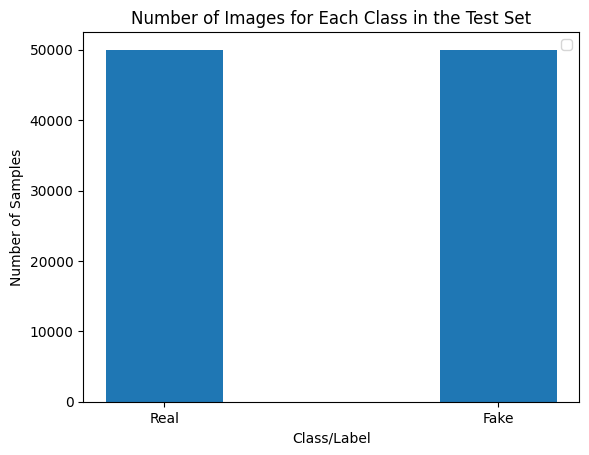

In [14]:
# Observe the number of images for each class in testset
real_count_train = sum(label == 0 for label in train_set.targets)
fake_count_train = sum(label == 1 for label in train_set.targets)

# Define labels and counts
labels = ['Real', 'Fake']
test_counts = [real_count_train, fake_count_train]

# Set up the bar chart
fig, ax = plt.subplots()
index = range(len(labels))

# Plot test set counts
bar1 = ax.bar(index, test_counts, width=0.35)

# Add labels, title, and legend
ax.set_xlabel('Class/Label')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Images for Each Class in the Test Set')
ax.set_xticks([i for i in index])
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Applying transformations and visualizing them helps ensure that the data preprocessing and augmentation pipeline is correctly implemented before we start the training.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new / unseen data,
ultimately improving the model's performance and ensuring robustness.

We further split the training set into 80/20 training and validation sets.

In [15]:
len_img=len(train_set)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_set,val_set=random_split(train_set,
                             [len_train,len_val]) # random split 80/20

print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
# TO-DO: Another graph now that we have a val set as well

Training set size: 80000
Validation set size: 20000


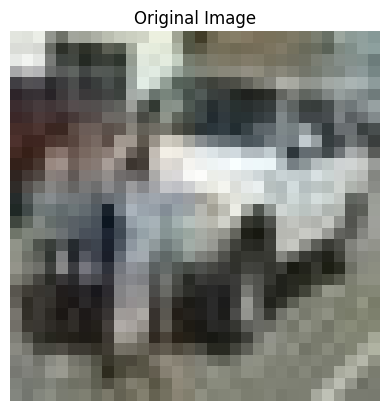

In [16]:
img, label = val_set[2] # TO-DO: Can we pick the image of a cat?

# Convert PIL Image to numpy array
img_np = np.array(img)

# Visualize the original image
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

## The preprocessing for validation set

In [22]:
train_set.dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 0)

In [9]:
# TO-DO: Create function for the transformation (train/val set)
val_transform = v2_transforms.Compose([
    # Resize image to 232 x 232
    # All images have a uniform size, which is required for batch processing in neural networks
    # v2_transforms.Resize(size=(232, 232), interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2_transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BILINEAR, antialias=True),

    # Ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.
    v2_transforms.CenterCrop(224),

    # Converts the image from a PIL Image or numpy array to a tensor.
    # Changes the data range from [0, 255] to [0.0, 1.0].
    v2_transforms.ToImage(),
    v2_transforms.ToDtype(torch.float32, scale=True),

    # Applies the normalization operation to each channel using the specified mean and standard deviation.
    # Uncomment the following line to include normalization.
    # v2_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# Load the validation dataset and apply the transformation
val_set.dataset.transform = val_transform

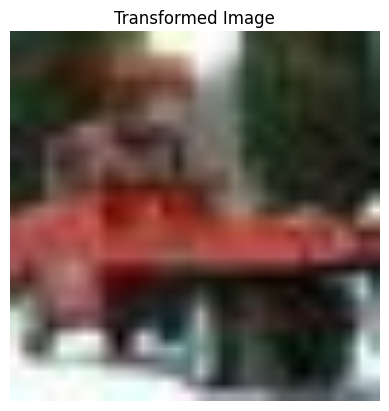

In [14]:
img, label = val_set[2]

val_transformed_img = val_transform(img)

# Convert PyTorch tensor to numpy array and rearrange dimensions
val_transformed_img_np = np.transpose(val_transformed_img .numpy(), (1, 2, 0))

# Convert PyTorch tensor to numpy array and rearrange dimensions
img_np = np.transpose(img.numpy(), (1, 2, 0))

# Visualize the transformed image
plt.imshow(val_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image")
plt.show()


Augmentation techniques (e.g. random rotations, flips, color jittering) are typically applied only to the training set. The purpose of data augmentation is to artificially expand the training set and help the model generalize better by learning from varied examples. In other words, we don't want our model to fixate on irrelevant features like orientation, but capture the important ones instead. Augmentation should not be applied to the validation set because it should represent the true distribution of data the model will encounter in real-world scenarios.
:

## The preprocesing for the training set

In [ ]:
train_transform = v2.Compose([
    # resize image to 232 x 232
    ## all images have a uniform size, which is required for batch processing in neural networks
    # v2.Resize(size=(232, 232), interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2.Resize(size=(224, 224), interpolation=InterpolationMode.BILINEAR, antialias=True),

    ##ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.
    v2.CenterCrop(224),

    # data augmentation

    ##Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.
    v2.RandomHorizontalFlip(p=0.5),

    ##Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.
    v2.RandomRotation(degrees=30),

    ##Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.
    v2.ColorJitter(brightness=.3, contrast = 0.3),

    ## Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.
    v2.RandomChannelPermutation(),
    # convert PIL image to tensor with image values in [0, 1]

    v2.ToImage(), # ToTensor() is deprecated

    v2.ToDtype(torch.float32, scale=True)

    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load the train dataset and apply the transformation
train_set.dataset.transform = train_transform

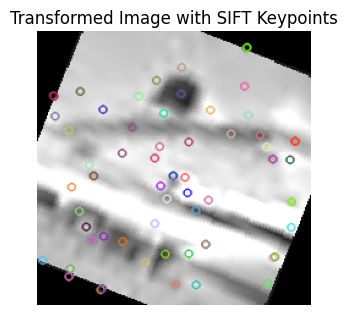

In [ ]:
img, label = train_set[1]

train_transformed_img = train_transform(img)

# Convert PyTorch tensor to numpy array and rearrange dimensions
train_transformed_img_np = np.transpose(train_transformed_img.numpy(), (1, 2, 0))


# Convert to uint8 for OpenCV
train_transformed_img_np_uint8 = (train_transformed_img_np * 255).astype(np.uint8)


# Convert the transformed image to a tensor and add a batch dimension
#Train_transformed_img = transforms.ToTensor()(Train_transformed_img)
train_transformed_img = train_transformed_img.unsqueeze(0)

#-----------------------------------------------------------#

#Εδω κανουμε με resnet feature extraction , το κανω remark για να το δουμε στο Transfer learning!#

# # Load a pretrained ResNet model (Residual Network)
#  model = models.resnet50(pretrained=True)

# feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# # # Ensure the model is in evaluation mode
# feature_extractor.eval()

# # # Extract features
# with torch.no_grad():features = feature_extractor(Train_transformed_img).squeeze()

# # # Convert features to a numpy array for further processing if needed
# features_np = features.numpy()

#------------------------------------------------------------#

# Convert the transformed image to numpy array for SIFT
train_transformed_img = train_transformed_img.squeeze().permute(1, 2, 0).numpy()
train_transformed_img = np.clip((train_transformed_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])), 0, 1)
train_transformed_img = (train_transformed_img * 255).astype(np.uint8)

# ##Scale-Invariant Feature Transform (SIFT) algorithm to detect and visualize keypoints in a grayscale version of the image. --SIFT works on single-channel images, so the RGB image is converted to grayscale.
gray = cv2.cvtColor(train_transformed_img_np_uint8, cv2.COLOR_RGB2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
key_points = sift.detect(gray, None)

# Draw keypoints on the image
img_with_kp = cv2.drawKeypoints(gray, key_points, None)

# Create a figure
fig = plt.figure(figsize=(12, 6))

# Convert image from BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

fig.add_subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Transformed Image with SIFT Keypoints")
plt.show()



## Training

In [ ]:
# Batch size - change if we get an Out Of Memory error
batch_size = 16

# Training data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

# Test data loaders
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, # No need to shuffle the test set
    num_workers=2, pin_memory=True
)

In [ ]:
# Neural net architecture
# It has two convolutional layers (conv1 and conv2) with ReLU activation functions, followed by max pooling layers (pool).
# The fully connected layers (fc1, fc2, and fc3) process the output of the convolutional layers.

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (input channel size (based on color channels of the image), output channel size, kernel size)
        self.pool = nn.MaxPool2d(2, 2) # (kernel size: 2x2, stride: move 2 pixels to the side)
        self.conv2 = nn.Conv2d(6, 16, 5) # input channel size = last output channel size
        # self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        self.fc3 = nn.Linear(84, 2) # 2 classes


# The forward method defines the forward pass of the network, where input x is passed through each layer sequentially.
# The view method reshapes the output of the second convolutional layer to be compatible with the fully connected layers. Finally, an instance of the Net class is created as net, representing the neural network model.

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()

In [ ]:
# For classification tasks calculates the loss between the predicted class probabilities and the actual class labels.
criterion = nn.CrossEntropyLoss() # Includes Softmax function
# Optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# TO-DO: Do we still need this?
# # Here we check if the batch size is diffent than the input

# # Iterate over the train_loader
# for i, data in enumerate(train_loader):
#     inputs, labels = data

#     # Check if batch size is different from 4
#     if inputs.size(0) != 4 or labels.size(0) != 4:
#         print(f"Batch {i + 1} has a different batch size: Input batch size: {inputs.size(0)}, Labels batch size: {labels.size(0)}")

In [ ]:
n_epochs = 20
total_steps = len(train_loader)

for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0 #is initialized to zero at the beginning of each epoch to keep track of the cumulative loss.
    for i, (images, labels) in enumerate(train_loader):
        # inputs, labels = data

# This clears the gradients of all optimized parameters.
# Gradients need to be reset to zero before starting
# backpropagation because PyTorch accumulates gradients on subsequent backward passes.
        # optimizer.zero_grad()

#This line passes the inputs through the model to get the outputs
        outputs = model(images)
#  The loss (error) between the model's
#  outputs and the actual labels is computed using a loss function (criterion).

        loss = criterion(outputs, labels)
# This computes the gradient of the loss
# with respect to the model parameters (weights and biases) via backpropagation.
        optimizer.zero_grad()
        loss.backward()
# This updates the model parameters based on the computed gradients.
# The optimizer adjusts the parameters to minimize the loss.
        optimizer.step()

# Every 2000 mini-batches, the average loss is printed.
# This provides feedback on the training process.
        running_loss += loss.item()

        # if i % 20000 == 1999:  # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 200))
        #     running_loss = 0.0

        if (i+1) % 100 == 0:
          print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}")

print('Finished Training')

Epoch [1/20], Step [100/5000], Loss: 0.6457
Epoch [1/20], Step [200/5000], Loss: 0.7826
Epoch [1/20], Step [300/5000], Loss: 0.7215
Epoch [1/20], Step [400/5000], Loss: 0.7438
Epoch [1/20], Step [500/5000], Loss: 0.6896
Epoch [1/20], Step [600/5000], Loss: 0.6087
Epoch [1/20], Step [700/5000], Loss: 0.6542
Epoch [1/20], Step [800/5000], Loss: 0.4959
Epoch [1/20], Step [900/5000], Loss: 0.6689
Epoch [1/20], Step [1000/5000], Loss: 0.6302
Epoch [1/20], Step [1100/5000], Loss: 0.5747
Epoch [1/20], Step [1200/5000], Loss: 0.5931
Epoch [1/20], Step [1300/5000], Loss: 0.5832
Epoch [1/20], Step [1400/5000], Loss: 0.5839
Epoch [1/20], Step [1500/5000], Loss: 0.4855
Epoch [1/20], Step [1600/5000], Loss: 0.5997
Epoch [1/20], Step [1700/5000], Loss: 0.5501
Epoch [1/20], Step [1800/5000], Loss: 0.4393
Epoch [1/20], Step [1900/5000], Loss: 0.5166
Epoch [1/20], Step [2000/5000], Loss: 0.5801
Epoch [1/20], Step [2100/5000], Loss: 0.2665
Epoch [1/20], Step [2200/5000], Loss: 0.3836
Epoch [1/20], Step 

KeyboardInterrupt: 

Total Iterations per Epoch:Given the training set size of 80,000 and a batch size of 64, the total number of iterations (mini-batches) per epoch is:

total_iterations = total_samples / batch_Size =
80000/64 = 1250
​

Printing Frequency:

You want to balance between too frequent and too infrequent logging. If you print too often, it might clutter the output and slightly slow down training due to I/O operations. If you print too infrequently, you might not get enough information to monitor training effectively.
A common approach is to print the running loss a few times per epoch.

For an 80,000-sample training set and a batch size of 64, a good approach could be to print the loss every 200 mini-batches. This way, you'll get around 6 updates per epoch (1250 iterations / 200 = 6.25), which provides a good balance between feedback frequency and performance overhead.

## Transfer learning